In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from yellowbrick.contrib.wrapper import wrap
from yellowbrick.regressor import ResidualsPlot

# Reading data

In [48]:
df = pd.read_csv("properties_v3.csv", sep=",")

In [49]:
df['neighbourhood'] = df['neighbourhood'].astype(str)

In [50]:
bool_cols = [col for col in df if 
               df[col].dropna().value_counts().index.isin([0,1]).all()]

In [51]:
# numerical_features = ["area", "rooms", "bathrooms", "garages"]
numerical_features = ["area", "bathrooms", "garages"]
categorical_features = ["neighbourhood"]
binary_features = bool_cols
target = "price"

In [52]:
df.isnull().sum()[:10]

index         76
id            76
url           76
header        76
address       76
area         104
rooms         76
bathrooms     76
garages       76
price        150
dtype: int64

Condominio muito missing:
Opcao 1a: Remover a coluna
Opcao 1b: Remover as observacoes faltantes
Opcao 2: Imputation (completar os valores faltantes)
Opcao 3: Usar mesmo assim

In [53]:
df = df.dropna(subset = ["area", "rooms", "bathrooms", "garages", "price"])

# Data pipeline

In [54]:
numerical_features

['area', 'bathrooms', 'garages']

In [55]:
scaler = MinMaxScaler()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features)], 
                                  remainder="passthrough")

In [56]:
X = df[numerical_features + categorical_features + binary_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [57]:
data_pipeline.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['area', 'bathrooms', 'garages'])])

In [58]:
X_train_transformed = data_pipeline.transform(X_train)
X_test_transformed = data_pipeline.transform(X_test)

In [59]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=numerical_features+categorical_features+binary_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=numerical_features+categorical_features+binary_features)

# Feature selection

In [60]:
selector = SelectKBest(score_func=mutual_info_regression, k="all")
selector.fit(X_train_transformed[numerical_features+binary_features], y_train)

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x000001ED3AAF18B0>)

In [61]:
pd.DataFrame(zip(numerical_features + binary_features, selector.scores_), columns=["feature", "score"]).sort_values("score", ascending=False).head(10)

,feature,score
0,area,0.626410
1,bathrooms,0.324905
2,garages,0.246512
62,Mobiliado,0.033478
9,Ar-condicionado,0.028529
3,Academia,0.025251
16,Churrasqueira,0.024859
67,Piscina,0.022400
46,Garagem,0.021764
52,Interfone,0.021339


# Fitting model

## Baseline - linear regression

In [62]:
scaler = MinMaxScaler()
ohe = OneHotEncoder()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features), 
                                   ("categorical", ohe, categorical_features)], 
                                  remainder="passthrough")

In [63]:
X = df[numerical_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [64]:
data_pipeline.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['area', 'bathrooms', 'garages']),
                                ('categorical', OneHotEncoder(),
                                 ['neighbourhood'])])

In [65]:
X_test

,area,bathrooms,garages,neighbourhood
3864,30.0,1.0,0.0,centro
2288,184.0,2.0,2.0,Mossunguê (Ecoville)
7946,195.0,2.0,0.0,batel
31,32.0,1.0,0.0,capao raso
6590,56.0,1.0,1.0,Bigorrilho
...,...,...,...,...
8359,22.0,1.0,0.0,centro
5151,26.0,1.0,0.0,centro
7059,36.0,1.0,0.0,agua verde
2576,277.0,1.0,4.0,batel


In [66]:
X_train_transformed = data_pipeline.transform(X_train)
X_test_transformed = data_pipeline.transform(X_test)

In [67]:
model = LinearRegression()

In [68]:
model.fit(X_train_transformed, y_train)

LinearRegression()

In [69]:
y_pred = model.predict(X_test_transformed)
y_pred_train = model.predict(X_train_transformed)

In [70]:
mape_lr = mean_absolute_percentage_error(y_test, y_pred)

In [71]:
r2_lr = r2_score(y_test, y_pred)

In [72]:
mape_lr_train = mean_absolute_percentage_error(y_train, y_pred_train)

In [73]:
r2_lr_train = r2_score(y_train, y_pred_train)

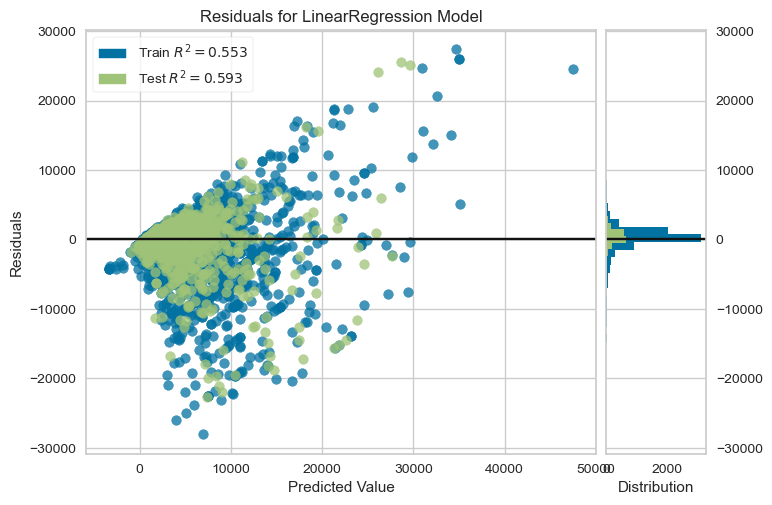

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [74]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_transformed, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)  # Evaluate the model on the test data
visualizer.show()         

## Random Forest

In [75]:
model = RandomForestRegressor(max_depth=4)
model.fit(X_train_transformed, y_train)

RandomForestRegressor(max_depth=4)

In [76]:
y_pred = model.predict(X_test_transformed)
y_pred_train = model.predict(X_train_transformed)

In [77]:
mape_rf = mean_absolute_percentage_error(y_test, y_pred)

In [78]:
r2_rf = r2_score(y_test, y_pred)

In [79]:
mape_rf_train = mean_absolute_percentage_error(y_train, y_pred_train)

In [80]:
r2_rf_train = r2_score(y_train, y_pred_train)

In [81]:
y_test.shape

(1926,)

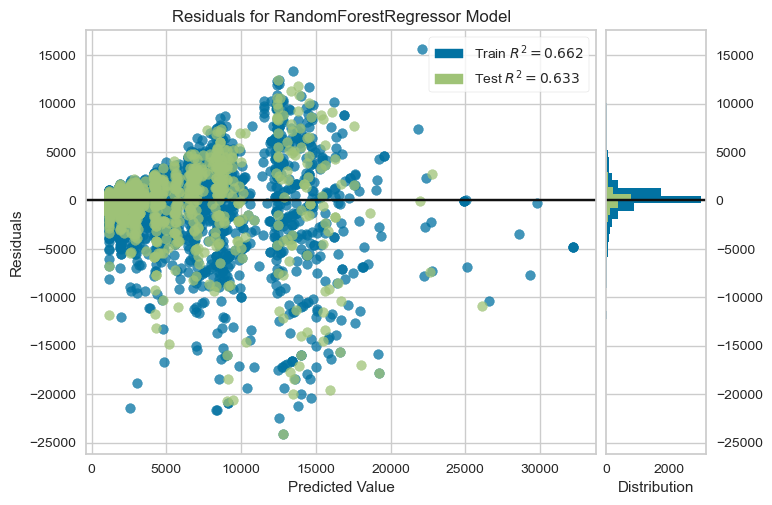

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [82]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_transformed, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)  # Evaluate the model on the test data
visualizer.show()         

# XGboost

In [83]:
model = XGBRegressor(max_depth=4)
model.fit(X_train_transformed, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
y_pred = model.predict(X_test_transformed)
y_pred_train = model.predict(X_train_transformed)

In [85]:
mape_xgboost = mean_absolute_percentage_error(y_test, y_pred)

In [86]:
r2_xgboost = r2_score(y_test, y_pred)

In [87]:
mape_xgboost_train = mean_absolute_percentage_error(y_train, y_pred_train)

In [88]:
r2_xgboost_train = r2_score(y_train, y_pred_train)

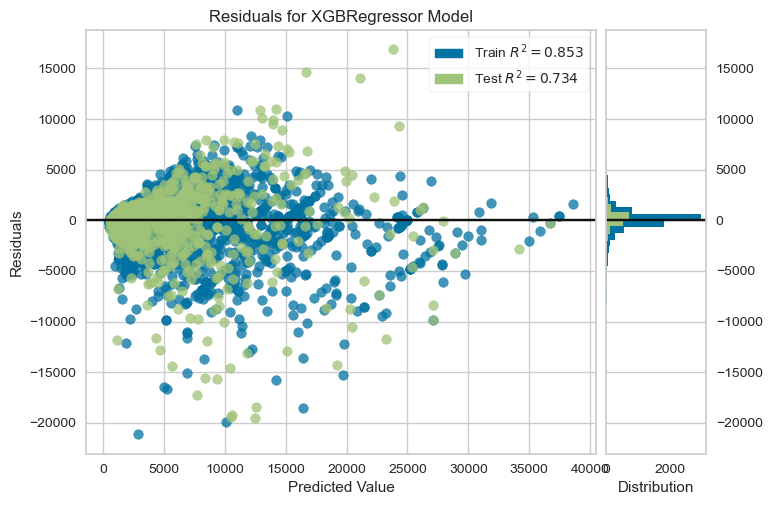

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [89]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_transformed, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)  # Evaluate the model on the test data
visualizer.show()         

# Catboost

In [90]:
scaler = MinMaxScaler()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features)], 
                                  remainder="passthrough")

In [91]:
X = df[numerical_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [92]:
data_pipeline.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['area', 'bathrooms', 'garages'])])

In [93]:
X_train_transformed = data_pipeline.transform(X_train)
X_test_transformed = data_pipeline.transform(X_test)

In [94]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=numerical_features+categorical_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=numerical_features+categorical_features)

In [95]:
model = CatBoostRegressor(cat_features=["neighbourhood"])
model.fit(X_train_transformed, y_train, eval_set=(X_test_transformed, y_test), verbose=False)

In [96]:
y_pred = model.predict(X_test_transformed)
y_pred_train = model.predict(X_train_transformed)

In [97]:
mape_catboost = mean_absolute_percentage_error(y_test, y_pred)

In [98]:
r2_catboost = r2_score(y_test, y_pred)

In [99]:
mape_catboost_train = mean_absolute_percentage_error(y_train, y_pred_train)

In [100]:
r2_catboost_train = r2_score(y_train, y_pred_train)

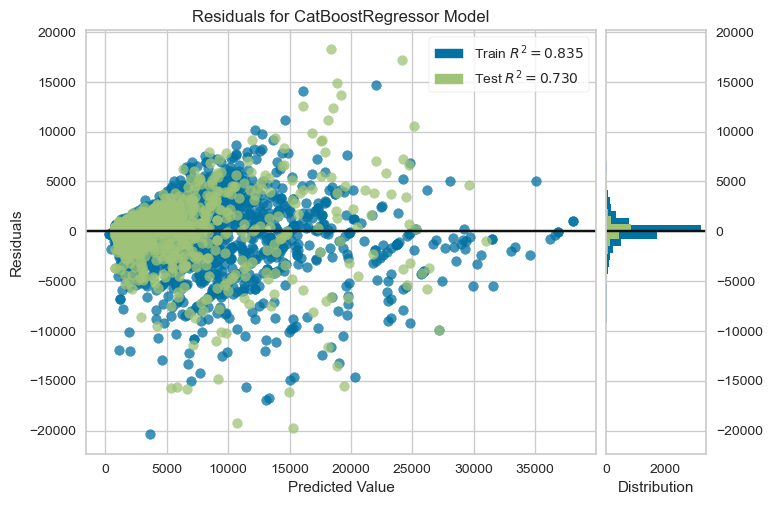

<AxesSubplot:title={'center':'Residuals for CatBoostRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [101]:
wrapped_model = wrap(model)
visualizer = ResidualsPlot(wrapped_model)

visualizer.fit(X_train_transformed, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)  # Evaluate the model on the test data
visualizer.show()         

In [102]:
### https://catboost.ai/

# Juntando

In [103]:
mapes = [mape_lr, mape_rf, mape_xgboost, mape_catboost]
r2s = [r2_lr, r2_rf, r2_xgboost, r2_catboost]
mapes_train = [mape_lr_train, mape_rf_train, mape_xgboost_train, mape_catboost_train]
r2s_train = [r2_lr_train, r2_rf_train, r2_xgboost_train, r2_catboost_train]

In [104]:
results = pd.DataFrame(zip(mapes, r2s, mapes_train, r2s_train), index=["linear_regression", "random_forest", "xgboost", "catboost"],
             columns=["mape", "r2", "mape_train", "r2_train"])

In [105]:
results.to_csv("resultados.csv")

In [106]:
results

,mape,r2,mape_train,r2_train
linear_regression,0.699311,0.592698,0.713261,0.553288
random_forest,0.561307,0.633076,0.575209,0.661898
xgboost,0.471864,0.734397,0.433801,0.852786
catboost,0.567884,0.730453,0.427053,0.834733
